# Visualizing, mapping, and predicting residential home prices paid in the UK to uncover investment opportunities

#### Written by: David Bender
#### February 2020

![title](map_cover_image.png)

### Real estate investment firms have to incorporate many factors when deciding where and how to invest. To simulate this challenge, in particular for residential real estate, this notebook will look at home prices across the UK and present several methods for analysing the data across various dimensions. As well, we will focus on a particular neighborhood - Islington - of London to offer a geospatial view of the data.

#### The data for this analysis is taken from the UK Prices Paid dataset that can be found at: https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads

#### For the sake of speed and cost, I have also provided intermediate datasets in the Github repository.

In [105]:
## First, let's import the relevant python packages

## Core packages for data wrangling, analysis, and charting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import datetime
from collections import Counter
import json
from pandas.io.json import json_normalize
import time
import re

## Mapping packages for presentation and geocoding
import folium
from folium.plugins import HeatMap
from folium import IFrame
import geopandas
import branca
import geopy
from geopy.geocoders import Nominatim
from shapely.geometry import Point
import rtree

## Statistics and machine learning packages
import scipy.stats as stats
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Regressor
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

%matplotlib inline

## Section 1: Importing and examining the data

In [ ]:
## import the whole dataset for 2018

*** Use this cell only if using the full dataset, London dataset is available in repository

## Data does not have column headers, so we set these up to add custom column names
column_labels = ['transaction_ID', 'price', 'transfer_date', 'postcode','property_type', 
              'new_build','duration', 'PAON', 'SAON', 'street', 'locality', 'town_city', 
              'district', 'county', 'PPD_category_type', 'record_status']

## Read in the UK Housing Prices Paid 2018 dataset
## requires chunking (importing it in pieces) as it is a large file
df_chunk = pd.read_csv("/Users/user/Desktop/Datasets/pp-2018.csv", names=column_labels,
                      iterator=True, chunksize=10000)

## concatenate the chunks into one DataFrame 
chunk_list = []  # append each chunk here 

# Each chunk is in df format
for chunk in df_chunk:      
    # Once the data filtering is done, append the chunk to list
    chunk_list.append(chunk)
    
# concat the list into dataframe 
df = pd.concat(chunk_list)

## Filter down to London only
df = df[df['town_city'] == 'LONDON']
print('There are {:,}'.format(len(df)) + ' records in London from 2018.')

In [106]:
## For future data importing, I have saved an intermediate dataset that is prefiltered
#df.to_csv('london_prices_paid_2018.csv')

df = pd.read_csv('london_prices_paid_2018.csv')
df.head()

,Unnamed: 0,transaction_ID,price,transfer_date,postcode,property_type,new_build,duration,PAON,SAON,street,locality,town_city,district,county,PPD_category_type,record_status,postcode_district,month,year
0,1032,{7011B109-D879-8ED6-E053-6B04A8C075C1},1205000,2018-05-25,SW13 0NZ,Terraced,Old,Freehold,6,NaN,CHARLES STREET,NaN,LONDON,RICHMOND UPON THAMES,GREATER LONDON,A,A,SW13,5,2018
1,1037,{7011B109-D87E-8ED6-E053-6B04A8C075C1},5200000,2018-06-04,SW19 7BW,Detached,Old,Freehold,8,NaN,ST MARYS ROAD,NaN,LONDON,MERTON,GREATER LONDON,A,A,SW19,6,2018
2,1046,{7011B109-D888-8ED6-E053-6B04A8C075C1},616000,2018-05-17,SW13 0PN,Terraced,Old,Freehold,51,NaN,RAILWAY SIDE,NaN,LONDON,RICHMOND UPON THAMES,GREATER LONDON,A,A,SW13,5,2018
3,1059,{7011B109-D895-8ED6-E053-6B04A8C075C1},620000,2018-05-30,SW14 8EZ,Terraced,Old,Freehold,22,NaN,MULLINS PATH,NaN,LONDON,RICHMOND UPON THAMES,GREATER LONDON,A,A,SW14,5,2018
4,1340,{666758D7-3BE8-3363-E053-6B04A8C0D74E},211500,2018-01-31,SE20 8DN,Flat,Old,Leasehold,55,NaN,ORCHARD GROVE,NaN,LONDON,BROMLEY,GREATER LONDON,A,A,SE20,1,2018


In [107]:
## We will create a couple new columns, which will help in our later analysis.
## These will be a trimmed postcode that correlates to postcode areas, as well as 
## month and year separated out from date column.

## Trim the postcode column down to the first set of characters (removing last 3)
df['postcode_district'] = [str(x)[:-4] for x in df.postcode]

## Convert transfer date to DateTime object
df['transfer_date'] = pd.to_datetime(df.transfer_date)

## Add month and year columns
df['month'] = df['transfer_date'].dt.month
df['year'] = df['transfer_date'].dt.year

In [108]:
## The values in three columns are not logical, so will convert these to more readable
## values.
prop_type_dict = {'D': 'Detached',
                 'S': 'Semi-detached',
                 'F': 'Flat',
                 'T': 'Terraced',
                 'O': 'Other'}

new_build_dict = {'N': 'Old',
                 'Y': 'New'}

duration_dict = {'F': 'Freehold',
                 'L': 'Leasehold'}

Add a conditional to this conversion so that if this notebook is run multiple times we won't get an error.

In [109]:
## Change the property type for more readability
if len(df['property_type'].iloc[0]) == 1:
    df['property_type'] = df['property_type'].map(prop_type_dict)

In [110]:
## Change the build type for more readability
if len(df['new_build'].iloc[0]) == 1:
    df['new_build'] = df['new_build'].map(new_build_dict)

In [111]:
## Change the Duration attribute for more readability
if len(df['duration'].iloc[0]) == 1:
    df['duration'] = df['duration'].map(duration_dict)

In [112]:
## Now we can look at what the dataset looks like after these changes and additions
df.head()

,Unnamed: 0,transaction_ID,price,transfer_date,postcode,property_type,new_build,duration,PAON,SAON,street,locality,town_city,district,county,PPD_category_type,record_status,postcode_district,month,year
0,1032,{7011B109-D879-8ED6-E053-6B04A8C075C1},1205000,2018-05-25,SW13 0NZ,Terraced,Old,Freehold,6,NaN,CHARLES STREET,NaN,LONDON,RICHMOND UPON THAMES,GREATER LONDON,A,A,SW13,5,2018
1,1037,{7011B109-D87E-8ED6-E053-6B04A8C075C1},5200000,2018-06-04,SW19 7BW,Detached,Old,Freehold,8,NaN,ST MARYS ROAD,NaN,LONDON,MERTON,GREATER LONDON,A,A,SW19,6,2018
2,1046,{7011B109-D888-8ED6-E053-6B04A8C075C1},616000,2018-05-17,SW13 0PN,Terraced,Old,Freehold,51,NaN,RAILWAY SIDE,NaN,LONDON,RICHMOND UPON THAMES,GREATER LONDON,A,A,SW13,5,2018
3,1059,{7011B109-D895-8ED6-E053-6B04A8C075C1},620000,2018-05-30,SW14 8EZ,Terraced,Old,Freehold,22,NaN,MULLINS PATH,NaN,LONDON,RICHMOND UPON THAMES,GREATER LONDON,A,A,SW14,5,2018
4,1340,{666758D7-3BE8-3363-E053-6B04A8C0D74E},211500,2018-01-31,SE20 8DN,Flat,Old,Leasehold,55,NaN,ORCHARD GROVE,NaN,LONDON,BROMLEY,GREATER LONDON,A,A,SE20,1,2018


In [ ]:
## Some summary statistics about the London prices paid dataset
df.describe()

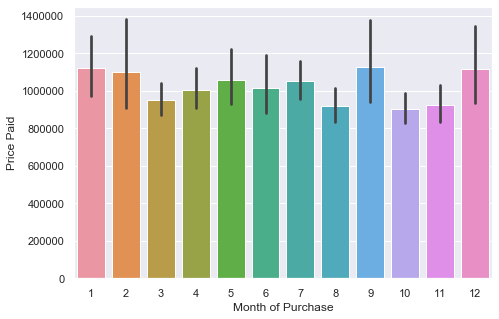

In [117]:
## With time data converted to month, we can see total value paid by month
plt.figure(figsize=(7.5,5))
sns.barplot(x=df.month, y=df.price)
plt.xlabel('Month of Purchase', fontsize=12)
plt.ylabel('Price Paid', fontsize=12)
plt.yscale('linear')
plt.show()

In [118]:
## Add in the population dataset for all UK postcode districts
## Data source: Nomis UK population database of all postcode districts and population density from
## 2011 - ONS Crown Copyright Reserved [from Nomis on 24 October 2019]

pop_density = pd.read_csv('/Users/user/Desktop/Datasets/UK_postcode_district_census.csv')
density_columns = ['geography code', 
                   'Variable: All usual residents; measures: Value',
                   'Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value',
                  'Variable: Area (Hectares); measures: Value']
pop_density = pop_density[density_columns]
rename_columns = ['postcode_district',
                 'all_residents',
                 'schoolchildren_pop',
                 'area_hectares']
pop_density.columns = rename_columns

pop_density.head(5)

,postcode_district,all_residents,schoolchildren_pop,area_hectares
0,AL1,36180,616,1055.02
1,AL10,35900,367,2023.54
2,AL2,23604,351,3734.88
3,AL3,28462,544,6803.77
4,AL4,27268,601,5299.97


Average price paid: £668,730.65.
Highest price paid: £2,715,000.00.
Standard deviation of prices paid in Islington: 336,575.36.


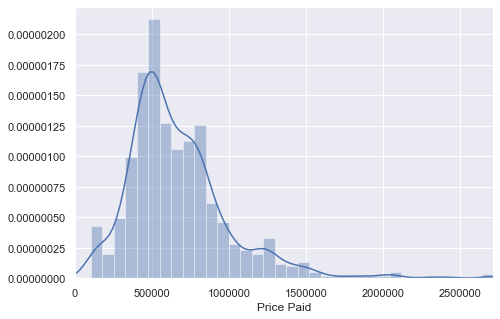

In [120]:
## Add the population density data to the prices paid dataset by merging the tables
## Used an if-statement to prevent multiple merges.
if 'all_residents' not in df.columns:
    df = df.merge(pop_density, how='left', on='postcode_district')

## To see the new merged dataset, we will take the example of flats in the Islington borough of London (EC postcodes)
Islington = df[df['postcode_district'].isin(['EC1','N1']) & df['property_type'].str.contains('Flat')]
print('Average price paid: £{:,.2f}.'.format(Islington['price'].mean()) + '\n' + \
      'Highest price paid: £{:,.2f}.'.format(Islington['price'].max()) + '\n' + \
      'Standard deviation of prices paid in Islington: {:,.2f}.'.format(Islington['price'].std()))

#fig, ax = plt.subplots()
plt.figure(figsize=(7.5,5))
plt.xlim(0,max(Islington.price))
sns.distplot(Islington['price'])
plt.xlabel('Price Paid')
plt.show()

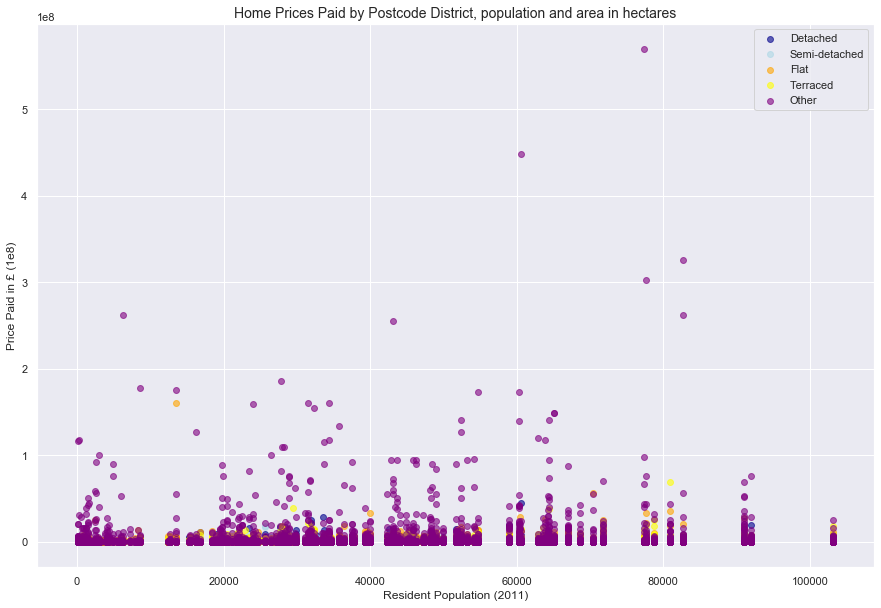

In [121]:
## Add a scatter plot of population to price
colors = {'Detached':'darkblue',
          'Semi-detached':'lightblue',
          'Flat':'orange',
          'Terraced':'yellow',
          'Other':'purple'}

legend = ['Detached','Semi-detached','Flat','Terraced','Other']

plt.figure(figsize=(15,10))

for x in colors:
    plt.scatter(x=sorted(df[df.property_type == x]['all_residents'],reverse=False),
    y=df[df.property_type == x]['price'],
    alpha=0.6,
    color=colors[x])

plt.xlabel('Resident Population (2011)',fontsize=12)
plt.ylabel('Price Paid in £ (1e8)',fontsize=12)
plt.title('Home Prices Paid by Postcode District, population and area in hectares', fontsize=14)
plt.legend(['Detached','Semi-detached','Flat','Terraced','Other'])

plt.show()

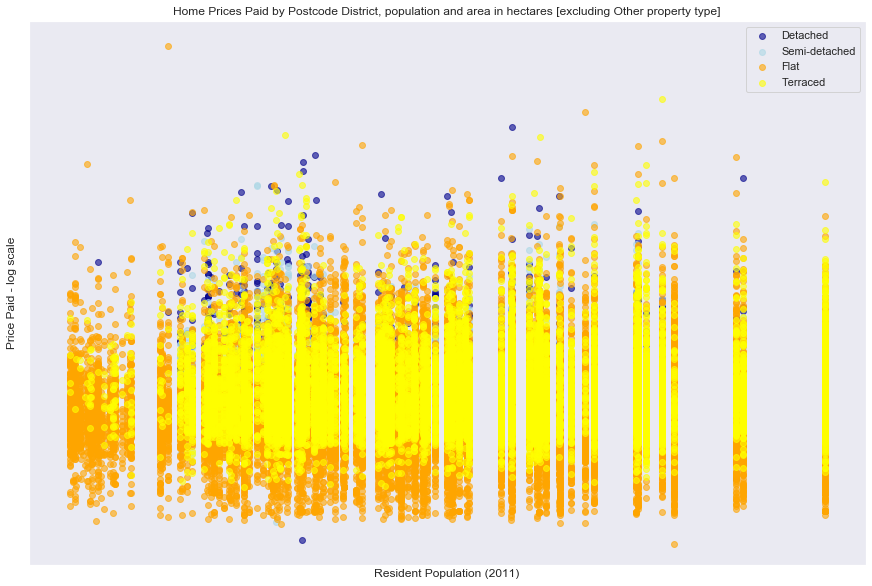

In [122]:
## This plot is showing that the 'Other' property type seems to dominate home prices.
## We will repeat the plot above but remove that property type to focus in on the other types.

prop_types = ['Detached','Semi-detached', 'Flat', 'Terraced']
scatter_df = df[df['property_type'].isin(prop_types)]

colors = {'Detached':'darkblue',
          'Semi-detached':'lightblue',
          'Flat':'orange',
          'Terraced':'yellow',
          'Other':'purple'}

plt.figure(figsize=(15,10))
for x in prop_types:
    plt.scatter(x=sorted(df[df.property_type == x]['all_residents'],reverse=False),
    y=df[df.property_type == x]['price'],
    alpha=0.6,
    color=colors[x])

plt.xlabel('Resident Population (2011)',fontsize=12)
plt.ylabel('Price Paid - log scale',fontsize=12)
plt.yscale('log') # Making the y-axis a logarithmic scale to better visualize the distribution of prices
plt.xticks(ticks=[])
plt.yticks(ticks=[])
plt.title('Home Prices Paid by Postcode District, population and area in hectares [excluding Other property type]')

plt.legend(colors,loc='upper right')

plt.show()

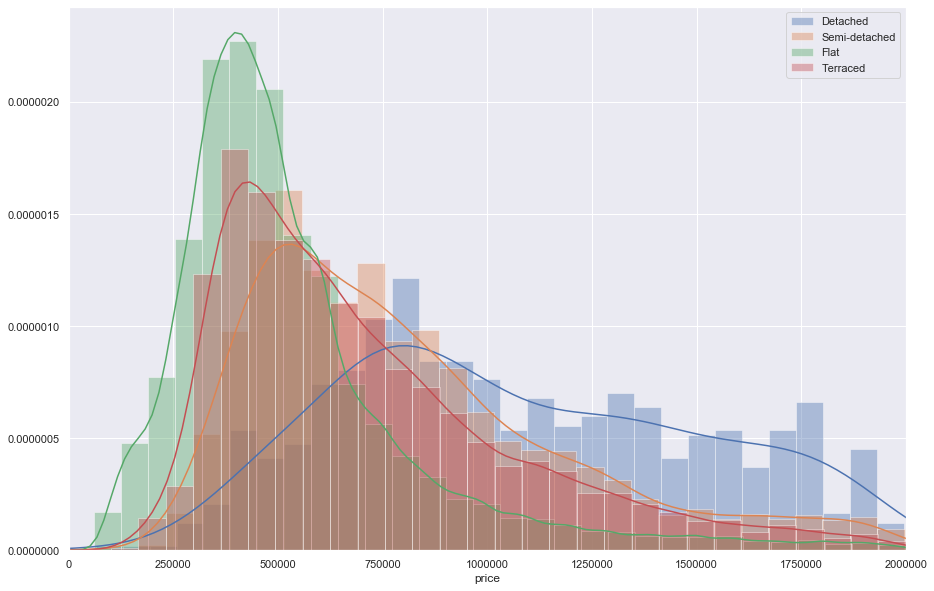

In [123]:
## Next, we will look at the distribution of prices paid by property type
## The dataset has some enormous outliers in price, so for this distribution we will only
## look at homes priced under £2,000,000.

max_price = 2000000
dist_df = df[df.price < max_price]

#_ = plt.subplot(2,2,2)
plt.figure(figsize=(15,10))
plt.xlim(0, max_price)
prop_type_list = ['Detached','Semi-detached','Flat','Terraced']

for x in prop_type_list:
    sns.distplot(dist_df[dist_df['property_type'] == x]['price'], bins=30)
    
plt.legend(prop_type_list)
plt.show()

# Section 2: Statistical Analysis and Mapping

In [124]:
## The difference between flats and terraced homes seems negligible.
## Is there a real difference between these property types in terms of price?
## We will perform a bootstrap analysis of these two property types from the dataset
## in the cell above to find if there is a genuine difference in prices.

n_size = 1000 # Will run bootstrap samples this many times
means = []
flat_means = []
terraced_means = []

for _ in range(n_size):
    bootstrap = dist_df.sample(len(Islington),replace=True)
    flat_mean = bootstrap[bootstrap.property_type == 'Flat'].price.mean()
    terraced_mean = bootstrap[bootstrap.property_type == 'Terraced'].price.mean()
    
    flat_means.append(flat_mean)
    terraced_means.append(terraced_mean)
    means.append(flat_mean - terraced_mean)

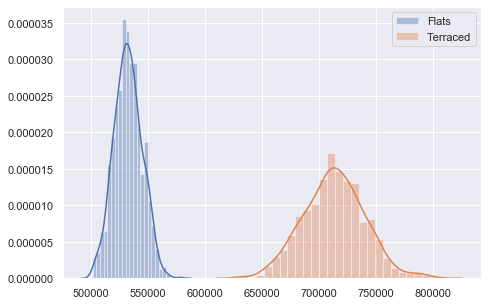

In [125]:
## Draw the two distributions of property type means
plt.figure(figsize=(7.5,5))
sns.distplot(flat_means, label='Flats')
sns.distplot(terraced_means, label='Terraced')
plt.legend()
plt.show()

In [126]:
ttest = stats.ttest_ind(flat_means, terraced_means)
ttest

Ttest_indResult(statistic=-192.93854369096266, pvalue=0.0)

 It looks like there is a very distinct difference between these property types, and that a flat is much more likely to be more affordable. Good information for someone from Canada, where 'Terraced' homes are not a category!

In [127]:
## Storing the credentials in a local file
credentials = pd.read_csv('/Users/user/Desktop/Datasets/credentials.csv')
google_api = credentials.iloc[0,1]

In [68]:
** This step has been replaced by the intermediate dataset in the repository **
## geotag the London data using Google's Geocoding service

Islington_homes = df[df['postcode_district'].isin(['EC1','N1'])]

#API_KEY = google_api
coordinates = []

## Sample of locations of homes
for x in range(len(Islington_homes)):
    address = str(Islington_homes.iloc[x]['PAON']) + ', ' + \
          str(Islington_homes.iloc[x]['street']) + ', ' + \
          str(Islington_homes.iloc[x]['town_city']) + ', ' + \
          str(Islington_homes.iloc[x]['district'])
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(address, API_KEY)
    r = requests.get(url)
    if r.json()['status'] == 'ZERO_RESULTS':
        lat_lng = 'NaN'
    else:
        lat_lng = [r.json()['results'][0]['geometry']['location']['lat'],
                r.json()['results'][0]['geometry']['location']['lng']]
    
        coordinates.append(lat_lng)

In [128]:
## Uncomment this section if using the cell above to geocode the locations differently

## The coordinates are saved as a dataset in the folder, and can be accessed below
# coordinates_df = pd.DataFrame()
# coordinates_df['coordinates'] = coordinates
# coordinates_df.to_csv('IslingtonCoordinates.csv')

## Or use the dataset available from the repository
coordinates_df = pd.read_csv('IslingtonCoordinates.csv')
Islington_homes = df[df['postcode_district'].isin(['EC1','N1'])]

In [129]:
## Merge the sample of coordinates with a slice of the dataset (will replace with full dataset later)
map_df = Islington_homes.reset_index(drop=True)
map_df = map_df.merge(coordinates_df, left_index=True, right_index=True)
map_df.head(3)

,Unnamed: 0_x,transaction_ID,price,transfer_date,postcode,property_type,new_build,duration,PAON,SAON,...,PPD_category_type,record_status,postcode_district,month,year,all_residents,schoolchildren_pop,area_hectares,Unnamed: 0_y,coordinates
0,29818,{7011B109-A524-8ED6-E053-6B04A8C075C1},1010000,2018-06-19,N1 1BY,Flat,Old,Leasehold,65B,NaN,...,A,A,N1,6,2018,91056.0,853.0,612.17,0,"[51.5395858, -0.1138834]"
1,29820,{7011B109-A526-8ED6-E053-6B04A8C075C1},1150000,2018-05-31,N1 3DL,Terraced,Old,Freehold,26,NaN,...,A,A,N1,5,2018,91056.0,853.0,612.17,1,"[51.5374278, -0.0890363]"
2,30242,{7C2D06FF-F5EF-4963-E053-6B04A8C07B97},1000000,2018-11-09,N1 6PB,Flat,Old,Leasehold,42,FLAT 3,...,A,A,N1,11,2018,91056.0,853.0,612.17,2,"[51.5272036, -0.08068439999999999]"


In [130]:
## The csv import converts the coordinates to a str type, so need to include some code
## to convert back to list. This would not be necessary if using the geocoding cell 
## to generate the coordinates.

lat_coordinates = []
lng_coordinates = []

for x in range(len(map_df)):
    string = map_df.iloc[x].coordinates
    string = string[1:-1]
    string = re.sub(',',' ', string)
    string = string.split()
    lat_coordinates.append(float(string[0]))
    lng_coordinates.append(float(string[1]))    
    
map_df['lat_coordinates'] = lat_coordinates
map_df['lng_coordinates'] = lng_coordinates

map_df.head()

,Unnamed: 0_x,transaction_ID,price,transfer_date,postcode,property_type,new_build,duration,PAON,SAON,...,postcode_district,month,year,all_residents,schoolchildren_pop,area_hectares,Unnamed: 0_y,coordinates,lat_coordinates,lng_coordinates
0,29818,{7011B109-A524-8ED6-E053-6B04A8C075C1},1010000,2018-06-19,N1 1BY,Flat,Old,Leasehold,65B,NaN,...,N1,6,2018,91056.0,853.0,612.17,0,"[51.5395858, -0.1138834]",51.539586,-0.113883
1,29820,{7011B109-A526-8ED6-E053-6B04A8C075C1},1150000,2018-05-31,N1 3DL,Terraced,Old,Freehold,26,NaN,...,N1,5,2018,91056.0,853.0,612.17,1,"[51.5374278, -0.0890363]",51.537428,-0.089036
2,30242,{7C2D06FF-F5EF-4963-E053-6B04A8C07B97},1000000,2018-11-09,N1 6PB,Flat,Old,Leasehold,42,FLAT 3,...,N1,11,2018,91056.0,853.0,612.17,2,"[51.5272036, -0.08068439999999999]",51.527204,-0.080684
3,30247,{7C2D06FF-F5F4-4963-E053-6B04A8C07B97},1100000,2018-10-29,N1 5AE,Terraced,Old,Freehold,60,NaN,...,N1,10,2018,91056.0,853.0,612.17,3,"[51.5401728, -0.07817049999999999]",51.540173,-0.078170
4,30736,{7E86B6FB-1A47-458C-E053-6B04A8C0C84C},1400000,2018-11-07,N1 1JZ,Detached,Old,Freehold,5,NaN,...,N1,11,2018,91056.0,853.0,612.17,4,"[51.54217449999999, -0.112727]",51.542174,-0.112727


In [131]:
## Add additional datasets that will be used - London boroughs
boroughs = geopandas.read_file('london_boroughs_proper.geojson')

In [132]:
## Now we will create the map with the borough layer and geocoded homes

london_centre = [51.5465, -0.1043]
london_map = folium.Map(location=london_centre, 
                        zoom_start=12,
                       tiles='cartodbpositron',
                       attr='CartoDB')

boroughs_shape = boroughs[boroughs['name'] != 'Islington']
islington_shape = boroughs[boroughs['name'] == 'Islington']

boroughs_collection = folium.FeatureGroup(name='Boroughs')

## Apply styling to Borough polygons
general_style = lambda feature: {'fillColor': 'lightgrey',
                        'color':"darkgrey",
                        'weight': 1,
                        'dashArray': '1, 1',
                        'fillOpacity': 0.3}

highlight_style = lambda feature: {'fillColor': 'blue',
                        'color':"darkgrey",
                        'weight': 3,
                        'fillOpacity': 0.4}

islington_style = lambda feature: {'fillColor': 'darkblue',
                        'color':"black",
                        'weight': 2,
                        'fillOpacity': 0.4}

folium.GeoJson(boroughs_shape, 
               style_function = general_style,
               highlight_function = highlight_style,
               tooltip=folium.GeoJsonTooltip(['name'], aliases=['Borough'])).add_to(boroughs_collection)

folium.GeoJson(islington_shape,
               style_function = islington_style, 
               tooltip=folium.GeoJsonTooltip(['name'], aliases=['Borough'],)).add_to(boroughs_collection)

boroughs_collection.add_to(london_map)


## Add the homes by iterating through the merged dataframe of prices paid and lat-lon coordiantes
homes_collection = folium.FeatureGroup(name='Homes', show=False)

for x in range(len(map_df)):
    tooltip = map_df.iloc[x]['price']
    marker = folium.Marker(location = [map_df.iloc[x].lat_coordinates,
                                       map_df.iloc[x].lng_coordinates],
                                 tooltip = '£{:,}'.format(tooltip))
    marker.add_to(homes_collection)
    
homes_collection.add_to(london_map)

## Add a heatmap view
HeatMap(zip(map_df.lat_coordinates,map_df.lng_coordinates),
        name='Heatmap',radius=10, min_opacity=0.5).add_to(london_map)

## Add layer controls and show the map
folium.LayerControl(collapsed=False).add_to(london_map)
london_map

/anaconda3/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


This looks good. But clearly there are a lot of homes that are outside of Islington, or were miscaptured when filtering by postcode district. This can be resolved using GeoPandas overlay and spatial join functions, but will look to use this package in a future notebook. We could also use those packages to perform other transformations and incorporate other spatial data.

## Section 3: Predictive modelling

### For predictive modelling, first we will preprocess the data to ensure it can by properly read by the scikit-learn packge. This involves converting ordinal (categorical) data into numerical data.

In [133]:
df_no_other = df[df.property_type != 'Other'] ## As seen above, 'Other' property type has major outliers

In [134]:
## Create a new dataframe using the function created above to capture the attributes
## to use in the prediction. Note that we will use the full London dataset for this.

category_attributes = ['property_type',
                       'postcode_district',
                       'new_build',
                       'duration']
df_attr = df_no_other[category_attributes]
df_attr.head()

,property_type,postcode_district,new_build,duration
0,Terraced,SW13,Old,Freehold
1,Detached,SW19,Old,Freehold
2,Terraced,SW13,Old,Freehold
3,Terraced,SW14,Old,Freehold
4,Flat,SE20,Old,Leasehold


In [135]:
## It is necessary to encode the categorical data, will use sci-kit's OneHotEncoder
enc = OneHotEncoder(sparse=False)
encoded = enc.fit_transform(df_attr)
encoded = pd.DataFrame(encoded)

encoded['all_residents'] = df_no_other['all_residents']
encoded['price'] = df_no_other['price']
encoded = encoded.dropna()
encoded.head()

,0,1,2,3,4,5,6,7,8,9,...,165,166,167,168,169,170,171,172,all_residents,price
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,16190.0,1205000.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,77676.0,5200000.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,16190.0,616000.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,16830.0,620000.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,22881.0,211500.0


In [136]:
## Now we create the test and target sets for the Nearest Neighbours regression analysis
X = encoded.drop(columns=['price'])
y = encoded['price'].values

In [137]:
# Examines the shape of the new dataframe to use for our models
X.shape

(55341, 174)

In [138]:
#Split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [139]:
#Split dataset into train and test data
neigh = KNeighborsRegressor(n_neighbors=25)
neigh.fit(X_train, y_train)
neigh.predict(X_test)

array([596928.  , 438945.48, 638802.76, ..., 442398.  , 335116.  ,
       982672.16])

In [140]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(neigh.predict(X_test), y_test))

846704.859552985

That is a pretty big error, so we will try different K values for the nearest neighbours model to see which will improve our predictive power.

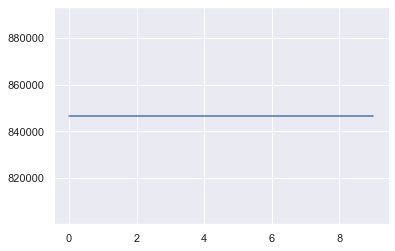

In [141]:
errors = []
neighbors_range = [20,30] # Initial runs show the predictive power very low below k=5

for x in range(neighbors_range[0],neighbors_range[1]):
    model = KNeighborsRegressor(n_neighbors=x)
    model.fit(X_train, y_train)
    model.predict(X_test)
    error = np.sqrt(mean_squared_error(neigh.predict(X_test), y_test))
    errors.append(error)

# Graph the results to identify best k-value
plt.plot(errors)
plt.show()

So, clearly the number of neighbors does not change the prediction error. It looks like we may not have sufficient data to make a good prediction but we can look at other models to see if there is an improvement...

### Assign the data to another scikit-learn package, Decision Trees

In [142]:
# Create Decision Tree classifer object
reg = DecisionTreeRegressor()

# Train Decision Tree Classifer
DTmodel = reg.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = DTmodel.predict(X_test)

In [143]:
y_train_pred = DTmodel.predict(X_train)

np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

756700.3521133146

The prediction errors are quite large, but can see that there are some differences between the models - which is good.

# Conclusion

The factors that we looked at to predict home prices have a fairly low predictive power, so we will likely have to find datasets with more features or develop features using some of the processes in the notebook.

In the future, we could explore spatial analysis tools to create new features or look for additional datasets to merge with the prices paid data that would add value for the predictions.